[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Market Metrics:
Annualized Return: 12.18%
Annualized Volatility: 22.12%
Sharpe Ratio: 0.55
Max Drawdown: -36.40%

Strategy Metrics:
Annualized Return: 17.98%
Annualized Volatility: 15.78%
Sharpe Ratio: 1.14
Max Drawdown: -15.75%


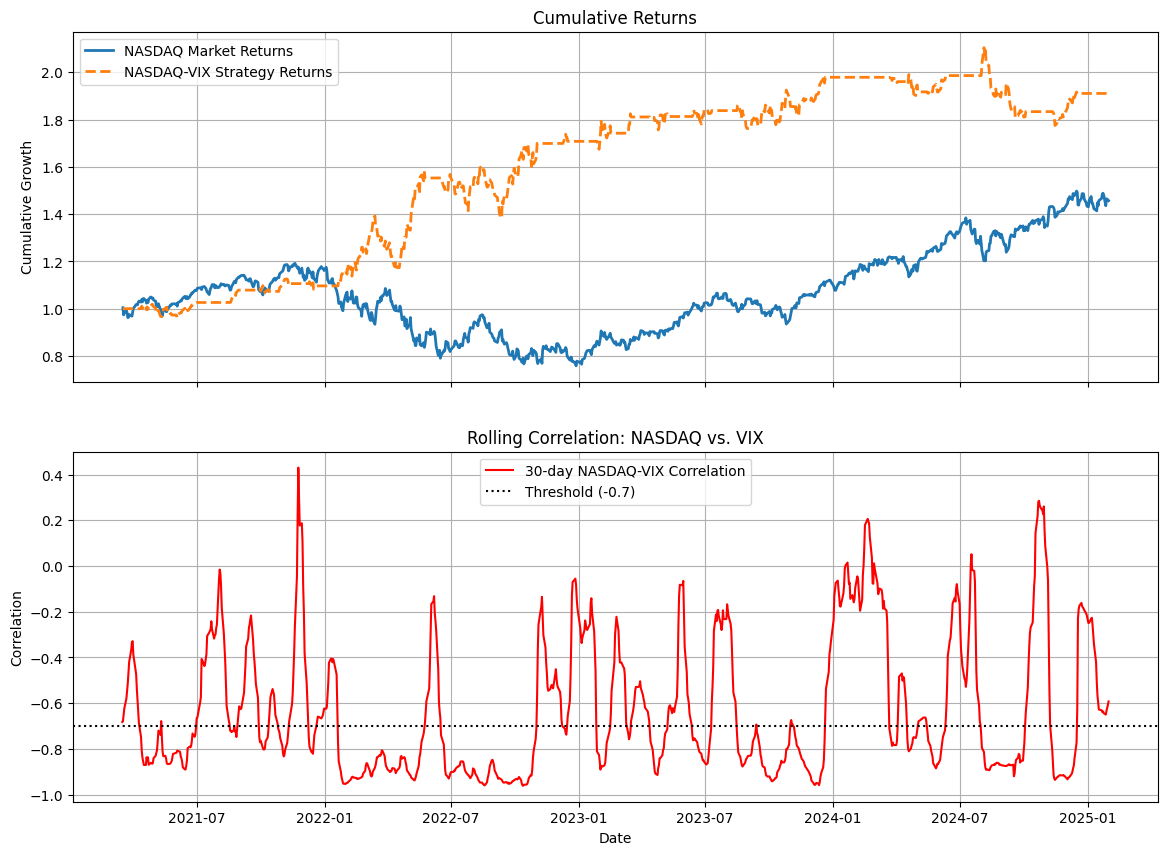

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Download NASDAQ and VIX data from Yahoo Finance
nasdaq = yf.download("^IXIC", start="2021-01-01", end="2025-02-01", interval="1d")
vix = yf.download("^VIX", start="2021-01-01", end="2025-02-01", interval="1d")

# Check for missing data
if nasdaq.isnull().values.any() or vix.isnull().values.any():
    print("Warning: Missing data detected. Consider filling or dropping missing values.")

# Merge data on the Date index
data = nasdaq[['Close']].join(vix[['Close']], how='inner', lsuffix='_nasdaq', rsuffix='_vix')
data.columns = ['nasdaq', 'vix']

# Compute rolling correlation and moving averages
data['correlation'] = data['nasdaq'].rolling(window=30).corr(data['vix'])
data['sma_10'] = data['nasdaq'].rolling(window=10).mean()
data['sma_50'] = data['nasdaq'].rolling(window=50).mean()

# Generate trading signals based on correlation and moving averages
data['signal'] = np.where((data['correlation'] < -0.7) & (data['sma_10'] > data['sma_50']), 1, 0)  # Long NASDAQ
data['signal'] = np.where((data['correlation'] < -0.7) & (data['sma_10'] < data['sma_50']), -1, data['signal'])  # Short NASDAQ

data['signal'] = data['signal'].shift(1)  # Avoid look-ahead bias

data.dropna(inplace=True)

# Calculate daily returns
data['nasdaq_returns'] = data['nasdaq'].pct_change()
data['strategy_returns'] = data['signal'] * data['nasdaq_returns']

# Implementing a simple stop-loss: Exit position if loss exceeds 3% in a day
data.loc[data['strategy_returns'] < -0.03, 'signal'] = 0
data['strategy_returns'] = data['signal'] * data['nasdaq_returns']

# Compute cumulative returns
data['cumulative_market_returns'] = (1 + data['nasdaq_returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# Performance Metrics
def calculate_metrics(returns):
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    mdd = max_drawdown(returns)
    return annualized_return, annualized_volatility, sharpe_ratio, mdd

market_metrics = calculate_metrics(data['nasdaq_returns'])
strategy_metrics = calculate_metrics(data['strategy_returns'])

# Print Metrics
print("Market Metrics:")
print(f"Annualized Return: {market_metrics[0]:.2%}")
print(f"Annualized Volatility: {market_metrics[1]:.2%}")
print(f"Sharpe Ratio: {market_metrics[2]:.2f}")
print(f"Max Drawdown: {market_metrics[3]:.2%}\n")

print("Strategy Metrics:")
print(f"Annualized Return: {strategy_metrics[0]:.2%}")
print(f"Annualized Volatility: {strategy_metrics[1]:.2%}")
print(f"Sharpe Ratio: {strategy_metrics[2]:.2f}")
print(f"Max Drawdown: {strategy_metrics[3]:.2%}")

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(data['cumulative_market_returns'], label="NASDAQ Market Returns", linewidth=2)
ax[0].plot(data['cumulative_strategy_returns'], label="NASDAQ-VIX Strategy Returns", linewidth=2, linestyle='dashed')
ax[0].set_title("Cumulative Returns")
ax[0].set_ylabel("Cumulative Growth")
ax[0].legend()
ax[0].grid()

ax[1].plot(data['correlation'], label="30-day NASDAQ-VIX Correlation", color='red', linewidth=1.5)
ax[1].axhline(y=-0.7, color='black', linestyle='dotted', label="Threshold (-0.7)")
ax[1].set_title("Rolling Correlation: NASDAQ vs. VIX")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Correlation")
ax[1].legend()
ax[1].grid()

plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


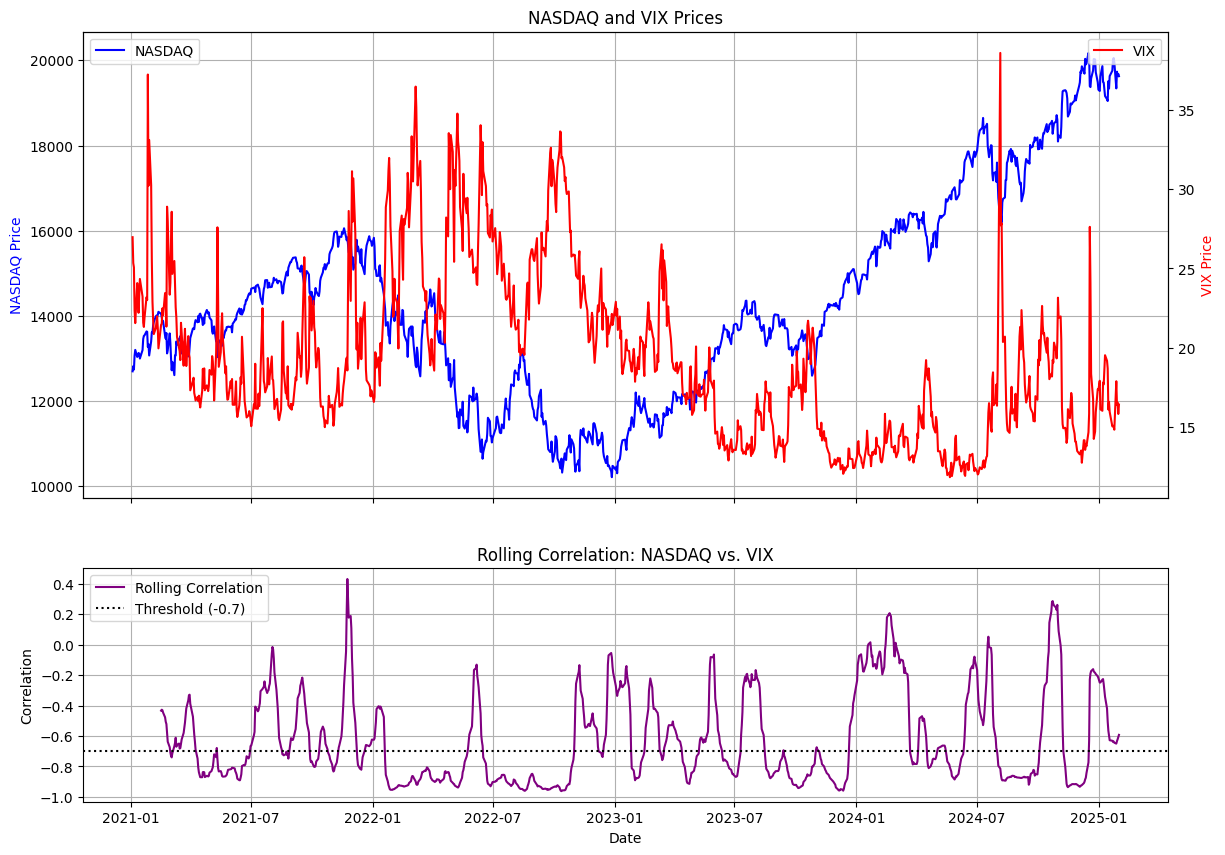

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Download NASDAQ and VIX data from Yahoo Finance
nasdaq = yf.download("^IXIC", start="2021-01-01", end="2025-02-01", interval="1d")
vix = yf.download("^VIX", start="2021-01-01", end="2025-02-01", interval="1d")

# Check for missing data
if nasdaq.isnull().values.any() or vix.isnull().values.any():
    print("Warning: Missing data detected. Consider filling or dropping missing values.")

# Merge data on the Date index
data = nasdaq[['Close']].join(vix[['Close']], how='inner', lsuffix='_nasdaq', rsuffix='_vix')
data.columns = ['nasdaq', 'vix']

# Compute rolling correlation
data['correlation'] = data['nasdaq'].rolling(window=30).corr(data['vix'])

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First row: NASDAQ and VIX Prices
ax1 = ax[0]
ax2 = ax1.twinx()

sns.lineplot(data=data, x=data.index, y='nasdaq', ax=ax1, label="NASDAQ", color='blue')
sns.lineplot(data=data, x=data.index, y='vix', ax=ax2, label="VIX", color='red')

ax1.set_ylabel("NASDAQ Price", color='blue')
ax2.set_ylabel("VIX Price", color='red')
ax1.set_title("NASDAQ and VIX Prices")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

# Second row: Rolling Correlation
sns.lineplot(data=data, x=data.index, y='correlation', ax=ax[1], color='purple', label="Rolling Correlation")
ax[1].axhline(y=-0.7, color='black', linestyle='dotted', label="Threshold (-0.7)")
ax[1].set_title("Rolling Correlation: NASDAQ vs. VIX")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Correlation")
ax[1].legend()
ax[1].grid()

plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Market Metrics:
Annualized Return: 12.18%
Annualized Volatility: 22.12%
Sharpe Ratio: 0.55
Max Drawdown: -36.40%

Strategy Metrics:
Annualized Return: 10.60%
Annualized Volatility: 10.48%
Sharpe Ratio: 1.01
Max Drawdown: -8.30%


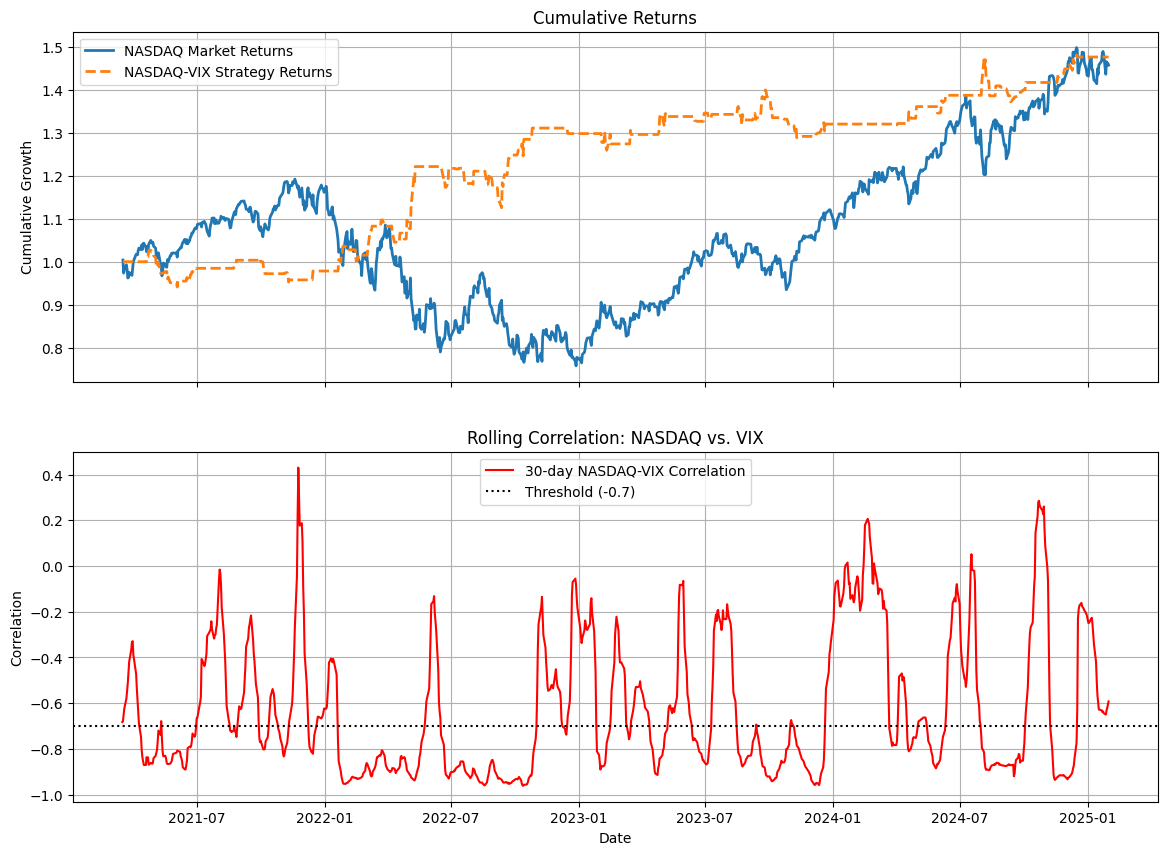

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Download NASDAQ and VIX data from Yahoo Finance
nasdaq = yf.download("^IXIC", start="2021-01-01", end="2025-02-01", interval="1d")
vix = yf.download("^VIX", start="2021-01-01", end="2025-02-01", interval="1d")

# Check for missing data
if nasdaq.isnull().values.any() or vix.isnull().values.any():
    print("Warning: Missing data detected. Consider filling or dropping missing values.")

# Merge data on the Date index
data = nasdaq[['Close']].join(vix[['Close']], how='inner', lsuffix='_nasdaq', rsuffix='_vix')
data.columns = ['nasdaq', 'vix']

# Compute rolling correlation and its first derivative
data['correlation'] = data['nasdaq'].rolling(window=30).corr(data['vix'])
data['correlation_change'] = data['correlation'].diff()

data['sma_10'] = data['nasdaq'].rolling(window=10).mean()
data['sma_50'] = data['nasdaq'].rolling(window=50).mean()

# Generate trading signals based on correlation trend and moving averages
data['signal'] = np.where((data['correlation'] < -0.7) & (data['correlation_change'] > 0) & (data['sma_10'] > data['sma_50']), 1, 0)  # Long NASDAQ
data['signal'] = np.where((data['correlation'] < -0.7) & (data['correlation_change'] < 0) & (data['sma_10'] < data['sma_50']), -1, data['signal'])  # Short NASDAQ

data['signal'] = data['signal'].shift(1)  # Avoid look-ahead bias
data.dropna(inplace=True)

# Calculate daily returns
data['nasdaq_returns'] = data['nasdaq'].pct_change()
data['strategy_returns'] = data['signal'] * data['nasdaq_returns']

# Implementing a simple stop-loss: Exit position if loss exceeds 3% in a day
data.loc[data['strategy_returns'] < -0.03, 'signal'] = 0
data['strategy_returns'] = data['signal'] * data['nasdaq_returns']

# Compute cumulative returns
data['cumulative_market_returns'] = (1 + data['nasdaq_returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# Performance Metrics
def calculate_metrics(returns):
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    mdd = max_drawdown(returns)
    return annualized_return, annualized_volatility, sharpe_ratio, mdd

market_metrics = calculate_metrics(data['nasdaq_returns'])
strategy_metrics = calculate_metrics(data['strategy_returns'])

# Print Metrics
print("Market Metrics:")
print(f"Annualized Return: {market_metrics[0]:.2%}")
print(f"Annualized Volatility: {market_metrics[1]:.2%}")
print(f"Sharpe Ratio: {market_metrics[2]:.2f}")
print(f"Max Drawdown: {market_metrics[3]:.2%}\n")

print("Strategy Metrics:")
print(f"Annualized Return: {strategy_metrics[0]:.2%}")
print(f"Annualized Volatility: {strategy_metrics[1]:.2%}")
print(f"Sharpe Ratio: {strategy_metrics[2]:.2f}")
print(f"Max Drawdown: {strategy_metrics[3]:.2%}")

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(data['cumulative_market_returns'], label="NASDAQ Market Returns", linewidth=2)
ax[0].plot(data['cumulative_strategy_returns'], label="NASDAQ-VIX Strategy Returns", linewidth=2, linestyle='dashed')
ax[0].set_title("Cumulative Returns")
ax[0].set_ylabel("Cumulative Growth")
ax[0].legend()
ax[0].grid()

ax[1].plot(data['correlation'], label="30-day NASDAQ-VIX Correlation", color='red', linewidth=1.5)
ax[1].axhline(y=-0.7, color='black', linestyle='dotted', label="Threshold (-0.7)")
ax[1].set_title("Rolling Correlation: NASDAQ vs. VIX")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Correlation")
ax[1].legend()
ax[1].grid()

plt.show()
